# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 1

Please use the following code to prepare the dataset.
 

In [1]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person', root_dir="/mnt/storage/Datasets/folktables")
acs_data = data_source.get_data(states=["CA"], download=True)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: round(round(float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex

data, data_original, target, group = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

In [2]:
group

array([1, 1, 1, ..., 1, 1, 1])

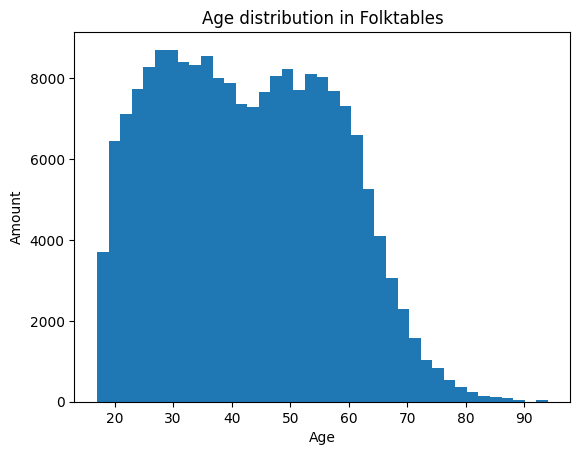

In [3]:
### Age plot to determine which kind of Scaler would be the most appropriate
data["AGEP"]
import matplotlib.pyplot as plt


plt.hist(data["AGEP"].values, bins = 39)
plt.title("Age distribution in Folktables")
plt.xlabel("Age")
plt.ylabel("Amount")

plt.show()


Text(0, 0.5, 'Amount')

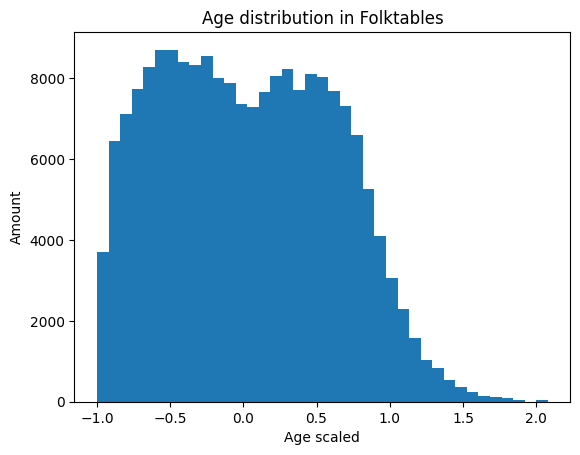

In [4]:
## We decideded on RobustScaler as we have quite skrewed distribution to the left
## we want to keep that distribution
from sklearn.preprocessing import RobustScaler, StandardScaler

age = data["AGEP"].values.reshape(-1,1)
scaler = RobustScaler()
age_scaled = scaler.fit_transform(age)

data["AGEP"] = age_scaled

plt.hist(data["AGEP"].values, bins = 39)
plt.title("Age distribution in Folktables")
plt.xlabel("Age scaled")
plt.ylabel("Amount")

In [5]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

In [6]:
from sklearn.linear_model import LogisticRegression

LogR = LogisticRegression(penalty ="elasticnet", C= 0.1, solver = "saga", l1_ratio=0.2).fit(X_train, y_train)

## penalty is elasticnet to get advantage of both l1 and l2 regularizations
## C = 0.1 is the strongest regularization that doesn't give deminishing returns
## solver saga is the only solver compatible with the elasticnet penalty
##l1 ratio is the most optimal one after testing

LogR.predict(X_test)
LogR.predict_proba(X_test)
LogR.score(X_test, y_test)


0.7702450617126211

#Answers: 
- Train a logistic regression, The age is rescaled with RobustScaler as the age it heavily right tailed skrewed. In this case we have few people with age 70,80,90 relatively to age 20,30,40... 
- Score 76.961 %


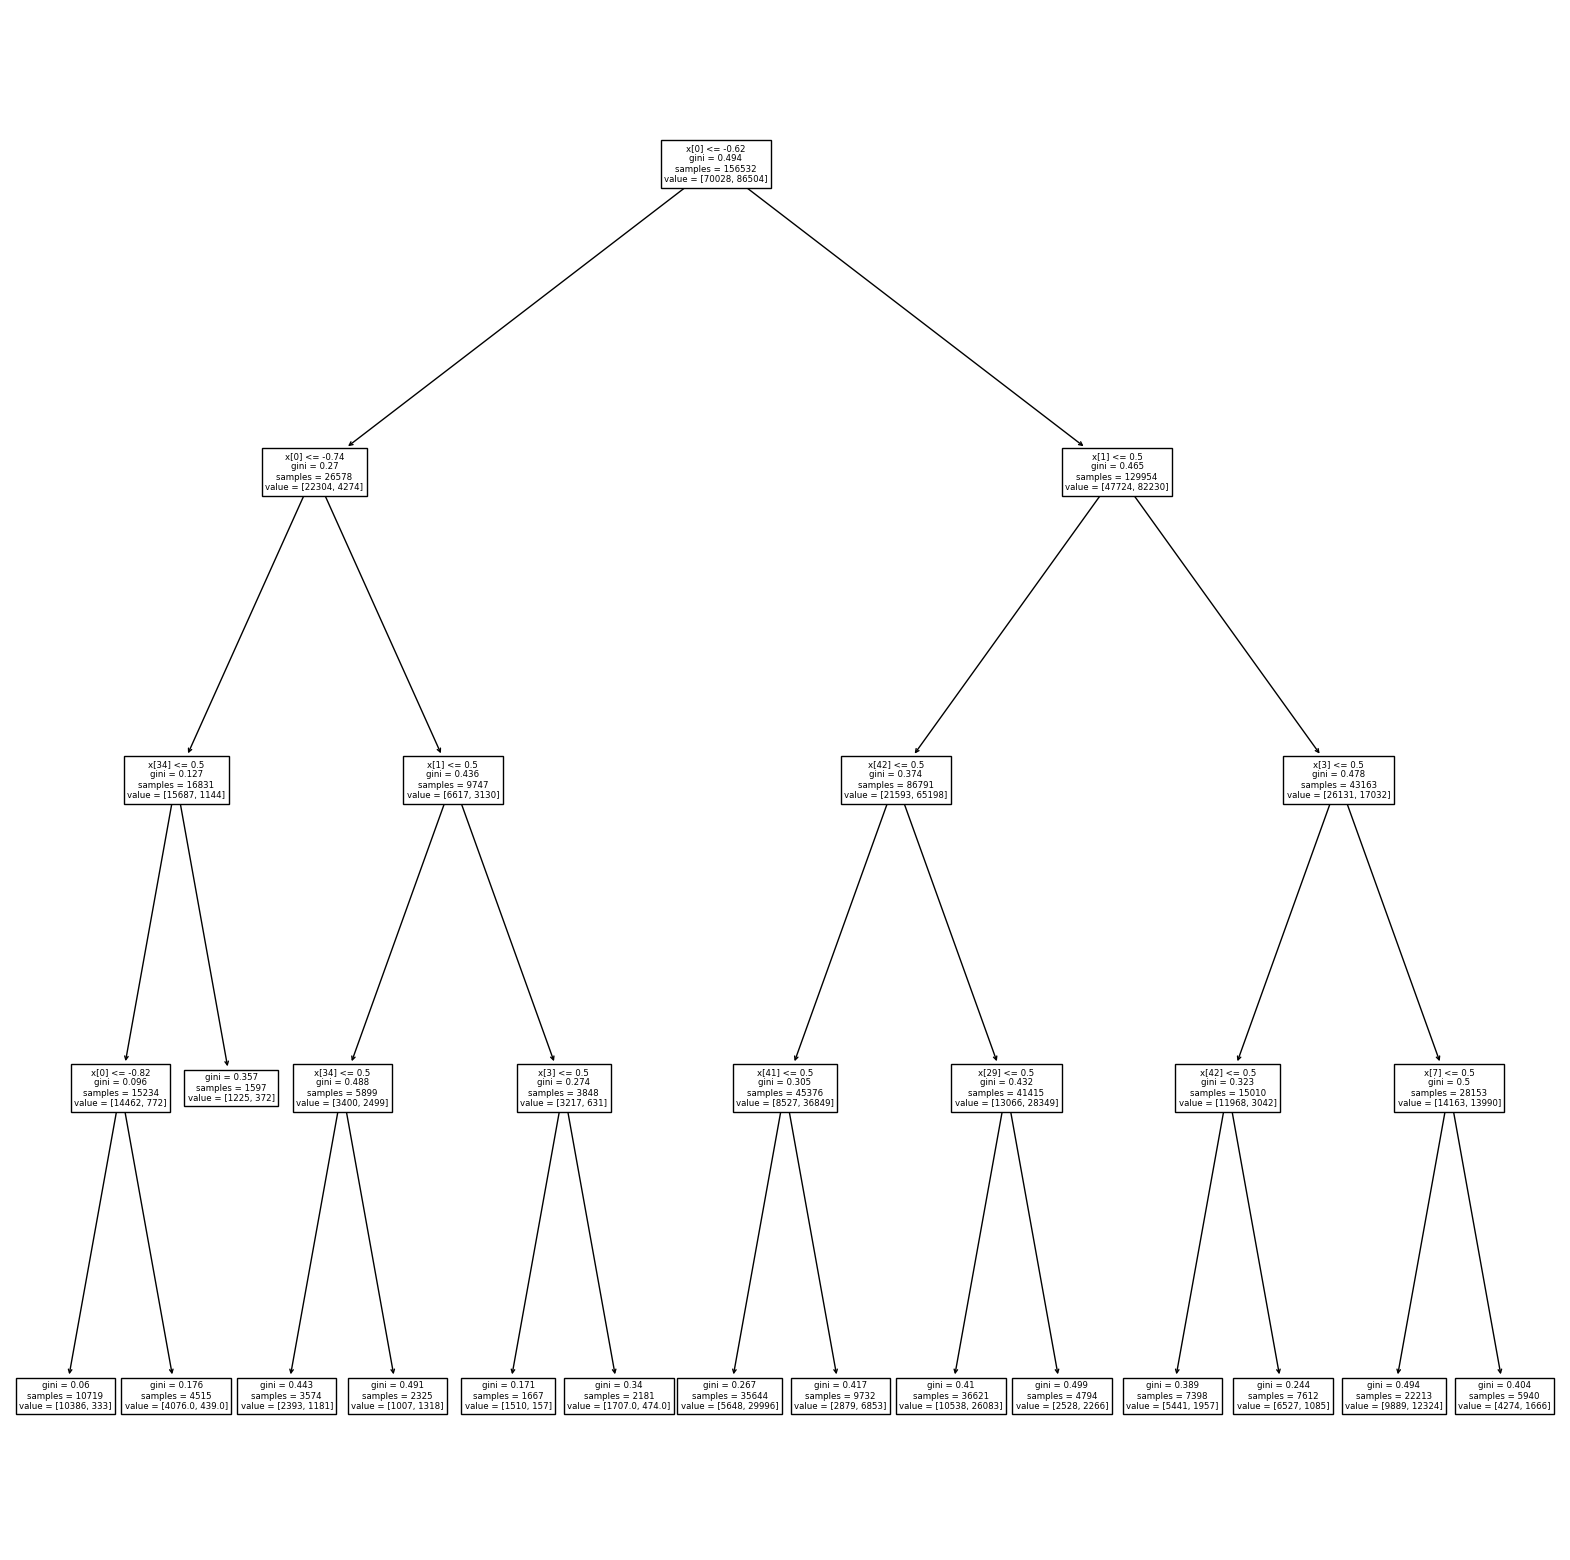

In [7]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(min_samples_split = 0.01, min_samples_leaf= 0.01,  max_depth = 4, criterion = "gini", random_state = 0)
# clf = tree.DecisionTreeClassifier(min_samples_split = 0.01, min_samples_leaf=0.001, max_depth=6, random_state=42)
clf = clf.fit(X_train, y_train)

plt.figure(figsize=(20,20))

tree.plot_tree(clf)
plt.show()


In [8]:
#X_train.columns

clf.score(X_test, y_test)

0.7469399228272813

In [9]:
import dtreeviz
import graphviz

<module 'dtreeviz.models' from '/home/thejarmanitor/miniconda3/envs/algfair/lib/python3.11/site-packages/dtreeviz/models/__init__.py'>


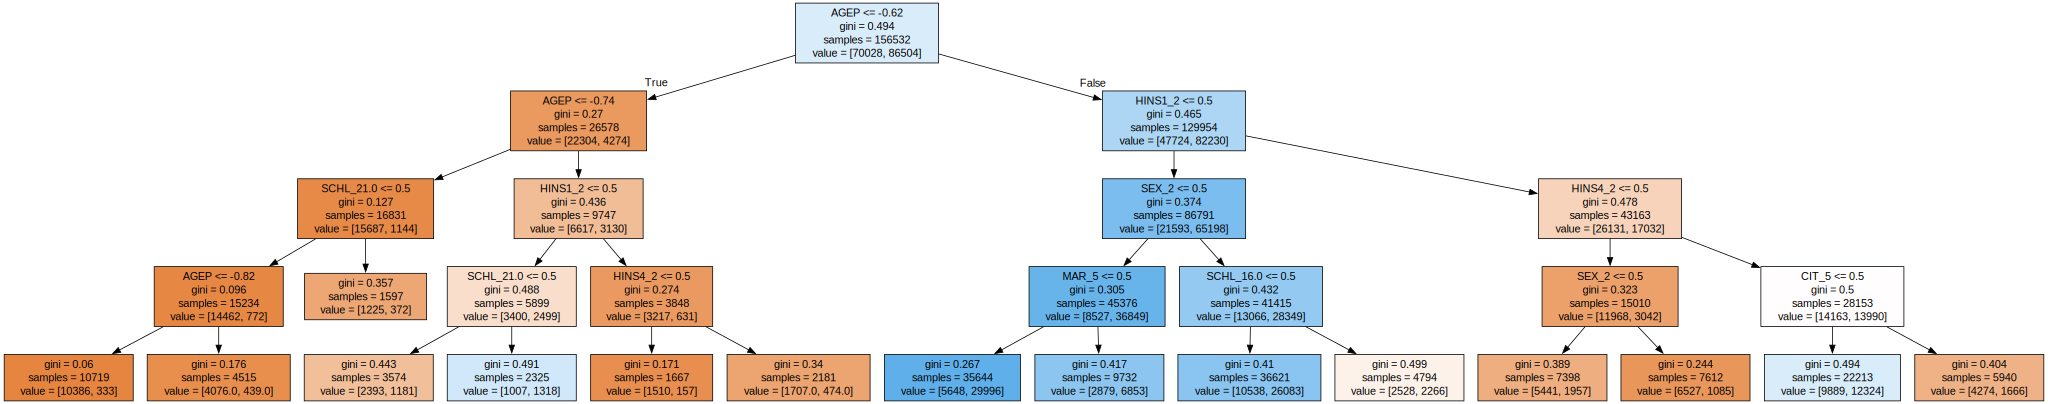

In [11]:
print(dtreeviz.models)
# DOT data
dot_data = tree.export_graphviz(clf, 
                                feature_names=X_train.columns,  
                                #class_names=iris.target_names,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [12]:
#https://github.com/parrt/dtreeviz/blob/master/notebooks/dtreeviz_sklearn_pipeline_visualisations.ipynb
viz_model = dtreeviz.model(clf, tree_index=1,
                           X_train = X_train, y_train = y_train,
                           feature_names=X_train.columns,
                           target_name=target_name)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

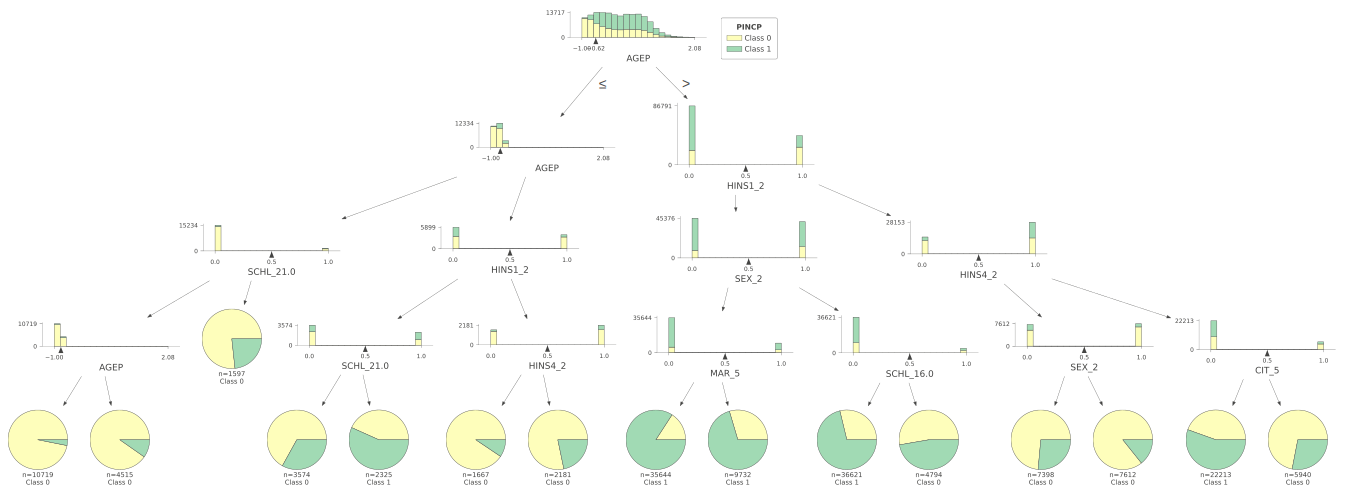

In [13]:
### To get specfic instance
# x = x_train.iloc[???]
#viz_model.view(x=x)

viz_model.view()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

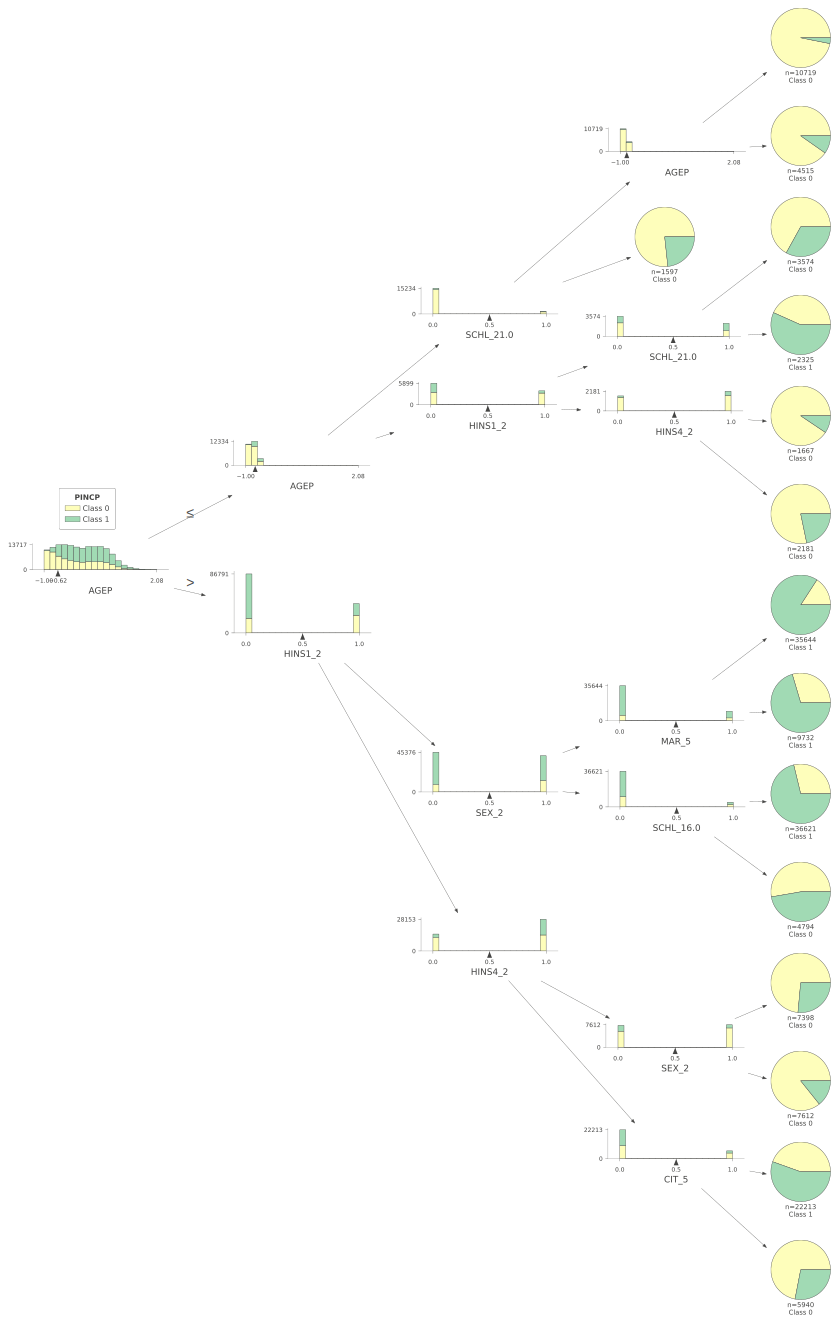

In [14]:
viz_model.view(orientation="LR")

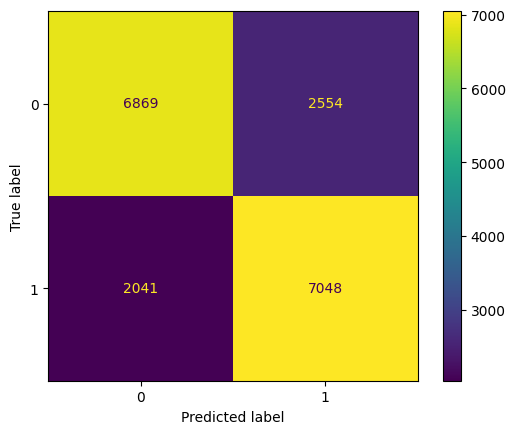

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_logR = LogR.predict(X_test)

y_pred_clf = clf.predict(X_test)

logR_male_preds = [i for (i, v) in zip(y_pred_logR, (group_test == 2)) if v]
logR_female_preds = [i for (i, v) in zip(y_pred_logR, (group_test == 1)) if v]

clf_male_preds = [i for (i, v) in zip(y_pred_clf, (group_test == 2)) if v]
clf_female_preds = [i for (i, v) in zip(y_pred_clf, (group_test == 1)) if v]

y_test_male = [i for (i, v) in zip(y_test, group_test) if v == 2]
y_test_female = [i for (i, v) in zip(y_test, group_test) if v == 1]

conf_matrix_male_logistic = confusion_matrix(y_test_male, logR_male_preds)
conf_matrix_female_logistic = confusion_matrix(y_test_female, logR_female_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_male_logistic)
disp.plot()
plt.show()

conf_matrix_male_clf = confusion_matrix(y_test_male, clf_male_preds)
conf_matrix_female_clf = confusion_matrix(y_test_female, clf_female_preds)






In [28]:
## Statistical Parity


## (TP + FN) / (TP + FN + FP + TN)
statistical_parity_logistic = {
    "male" : round(conf_matrix_male_logistic.sum(axis=0)[1]/len(y_test_male),2),
    "female" : round(conf_matrix_female_logistic.sum(axis=0)[1]/len(y_test_female),2)
}


statistical_parity_clf = {
    "male" : round(conf_matrix_male_clf.sum(axis=0)[1]/len(y_test_male),2),
    "female" : round(conf_matrix_female_clf.sum(axis=0)[1]/len(y_test_female),2)
}

## Equalized Odds

## TP / (TP + FN)
## FP / (FP + TN)

equalized_odds_logistic = {
    "true_positive":
        {
            "male": round(conf_matrix_male_logistic[1,1]/conf_matrix_male_logistic.sum(axis=0)[1],2),
            "female": round(conf_matrix_female_logistic[1,1]/conf_matrix_female_logistic.sum(axis=0)[1],2)
        },
    "false_positive":
        {
            "male": round(conf_matrix_male_logistic[0,1]/conf_matrix_male_logistic.sum(axis=0)[0],2),
            "female": round(conf_matrix_female_logistic[0,1]/conf_matrix_female_logistic.sum(axis=0)[0],2)
        }
}

equalized_odds_clf = {
    "true_positive":
        {
            "male": round(conf_matrix_male_clf[1,1]/conf_matrix_male_clf.sum(axis=0)[1],2),
            "female": round(conf_matrix_female_clf[1,1]/conf_matrix_female_clf.sum(axis=0)[1],2)
        },
    "false_positive":
        {
            "male": round(conf_matrix_male_clf[0,1]/conf_matrix_male_clf.sum(axis=0)[0],2),
            "female": round(conf_matrix_female_clf[0,1]/conf_matrix_female_clf.sum(axis=0)[0],2)
        }
}

## Equalized Outcomes

## TP / (TP + FP)
## FN / (TN + FN)

equalized_outcomes_logistic = {
    "true_positive":
        {
            "male": round(conf_matrix_male_logistic[1,1]/conf_matrix_male_logistic.sum(axis=1)[1],2),
            "female": round(conf_matrix_female_logistic[1,1]/conf_matrix_female_logistic.sum(axis=1)[1],2)
        },
    "false_negative":
        {
            "male": round(conf_matrix_male_logistic[1,0]/conf_matrix_male_logistic.sum(axis=1)[0],2),
            "female": round(conf_matrix_female_logistic[1,0]/conf_matrix_female_logistic.sum(axis=1)[0],2)
        }
}

equalized_outcomes_clf = {
    "true_positive":
        {
            "male": round(conf_matrix_male_clf[1,1]/conf_matrix_male_clf.sum(axis=1)[1],2),
            "female": round(conf_matrix_female_clf[1,1]/conf_matrix_female_clf.sum(axis=1)[1],2)
        },
    "false_negative":
        {
            "male": round(conf_matrix_male_clf[1,0]/conf_matrix_male_clf.sum(axis=1)[0]),
            "female": round(conf_matrix_female_clf[1,0]/conf_matrix_female_clf.sum(axis=1)[0],2)
        }
}

In [29]:
print("Statistical Parity Logistic Regression: ", statistical_parity_logistic)
print("Statistical Parity Decision Tree: ", statistical_parity_clf)
print("\n")
print("Equalized Odds Logistic Regression: ", equalized_odds_logistic)
print("Equalized Odds Decision Tree: ", equalized_odds_clf)

print("\n")
print("Equalized Outcomes Logistic Regression: ", equalized_outcomes_logistic)
print("Equalized Outcomes Decision Tree: ", equalized_outcomes_clf)

Statistical Parity Logistic Regression:  {'male': 0.52, 'female': 0.64}
Statistical Parity Decision Tree:  {'male': 0.64, 'female': 0.71}


Equalized Odds Logistic Regression:  {'true_positive': {'male': 0.73, 'female': 0.81}, 'false_positive': {'male': 0.29, 'female': 0.35}}
Equalized Odds Decision Tree:  {'true_positive': {'male': 0.66, 'female': 0.77}, 'false_positive': {'male': 0.62, 'female': 0.56}}


Equalized Outcomes Logistic Regression:  {'true_positive': {'male': 0.78, 'female': 0.85}, 'false_negative': {'male': 0.22, 'female': 0.23}}
Equalized Outcomes Decision Tree:  {'true_positive': {'male': 0.86, 'female': 0.9}, 'false_negative': {'male': 0, 'female': 0.15}}


/tmp/ipykernel_70715/2316787285.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


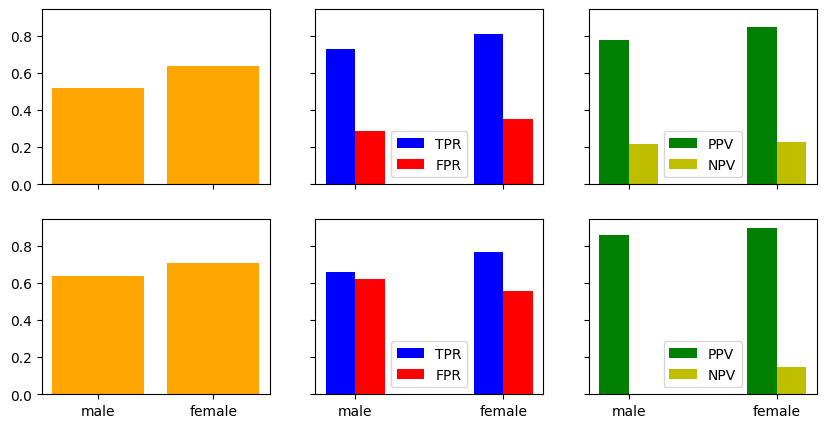

In [78]:
fig,ax = plt.subplots(2,3, figsize=(10,5), sharey=True)

#bar plot statistical parities for both models
ax[0,0].bar(statistical_parity_logistic.keys(), statistical_parity_logistic.values(), color='orange')
ax[0,0].set_xticklabels(["", ""])
ax[1,0].bar(statistical_parity_clf.keys(), statistical_parity_clf.values(), color='orange')

#bar plot for equalized odds for both models
ax[0,1].bar(np.arange(2), equalized_odds_logistic["true_positive"].values(), color='b', width=0.2, label="TPR")
ax[0,1].bar(np.arange(2)+0.2, equalized_odds_logistic["false_positive"].values(), color='r', width=0.2, label="FPR")
ax[0,1].set_xticks([0.1,1.1], ["", ""])
ax[0,1].legend()

ax[1,1].bar(np.arange(2), equalized_odds_clf["true_positive"].values(), color='b', width=0.2, label="TPR")
ax[1,1].bar(np.arange(2)+0.2, equalized_odds_clf["false_positive"].values(), color='r', width=0.2, label="FPR")
ax[1,1].set_xticks([0.1,1.1], ["male", "female"])
ax[1,1].legend()

#bar plot for equalized outcomesfor both models
ax[0,2].bar(np.arange(2), equalized_outcomes_logistic["true_positive"].values(), color='g', width=0.2, label="PPV")
ax[0,2].bar(np.arange(2)+0.2, equalized_outcomes_logistic["false_negative"].values(), color='y', width=0.2, label="NPV")
ax[0,2].set_xticks([0.1,1.1], ["", ""])
ax[0,2].legend()

ax[1,2].bar(np.arange(2), equalized_outcomes_clf["true_positive"].values(), color='g', width=0.2, label="PPV")
ax[1,2].bar(np.arange(2)+0.2, equalized_outcomes_clf["false_negative"].values(), color='y', width=0.2, label="NPV")
ax[1,2].set_xticks([0.1,1.1], ["male", "female"])
ax[1,2].legend()
            


### TPR: True Positive Rate
### FPR: False Positive Rate

### PPV: Positive Predictive Value
### NPV: Negative Predictive Value

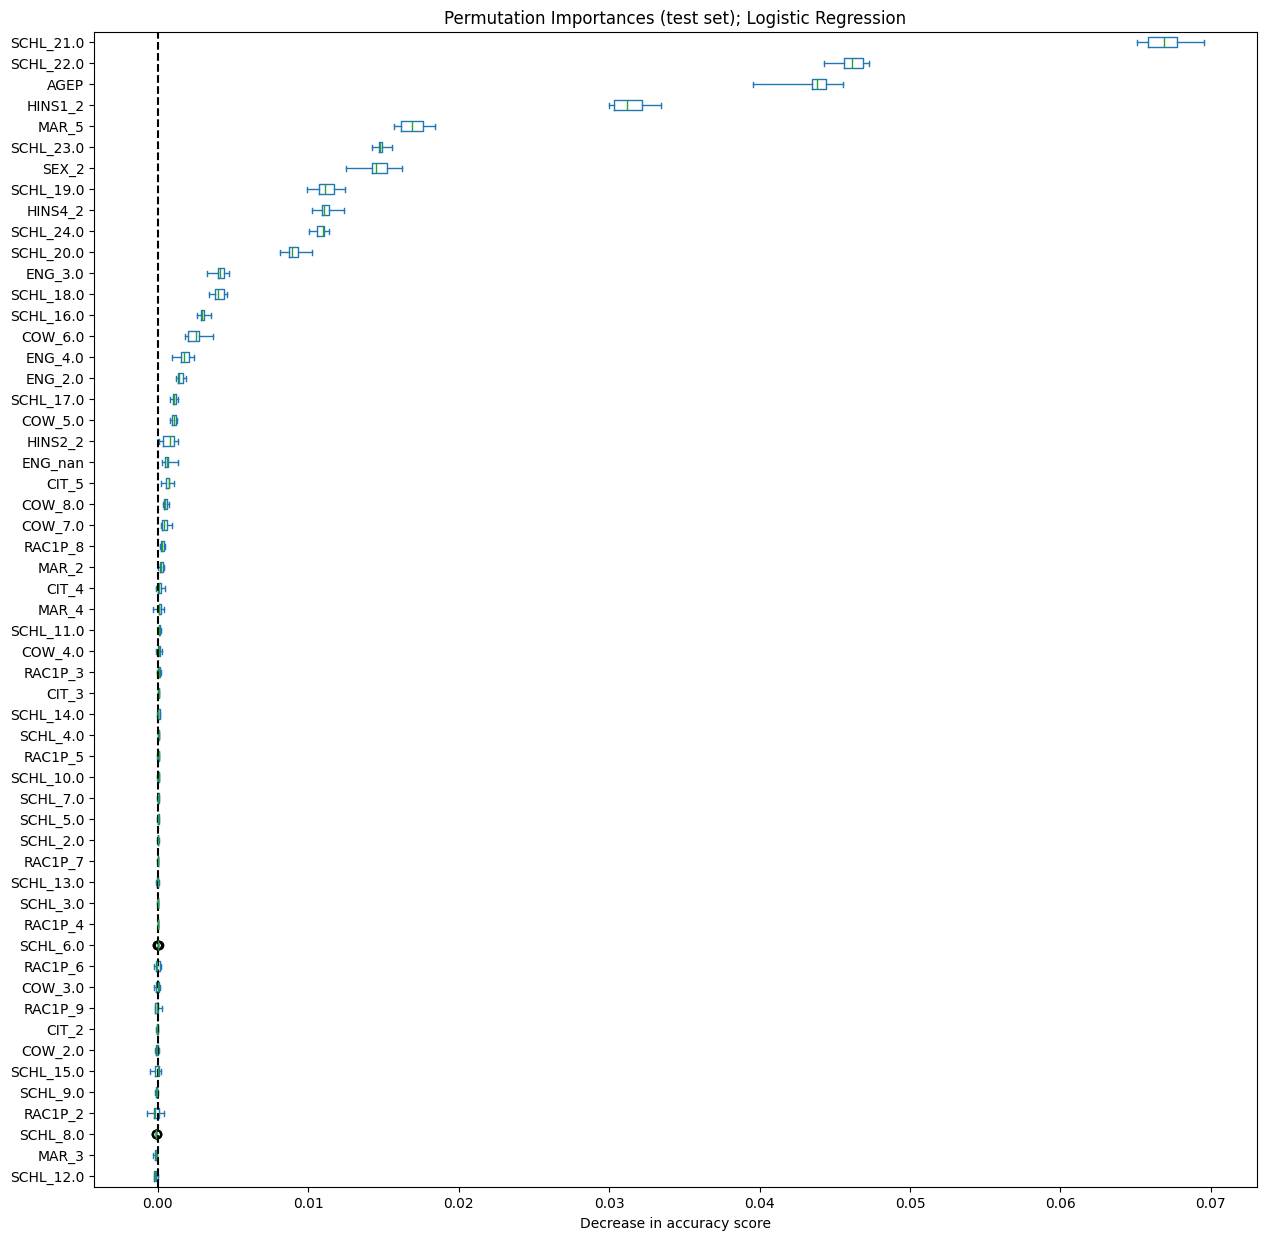

In [16]:
from sklearn.inspection import permutation_importance
LogR = LogisticRegression(max_iter=5000, penalty ="l2", C= 0.8497534359086438, tol = 1e-4, solver = "saga").fit(X_train, y_train)
#permutation_importance(LogR, X_test, y_test, n_repeats = 30, random_state = 0)
result = permutation_importance(
    LogR, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)

# Set the figure size
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the boxplot
importances.plot.box(ax=ax, vert=False, whis=10)
ax.set_title("Permutation Importances (test set); Logistic Regression")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")

plt.show()



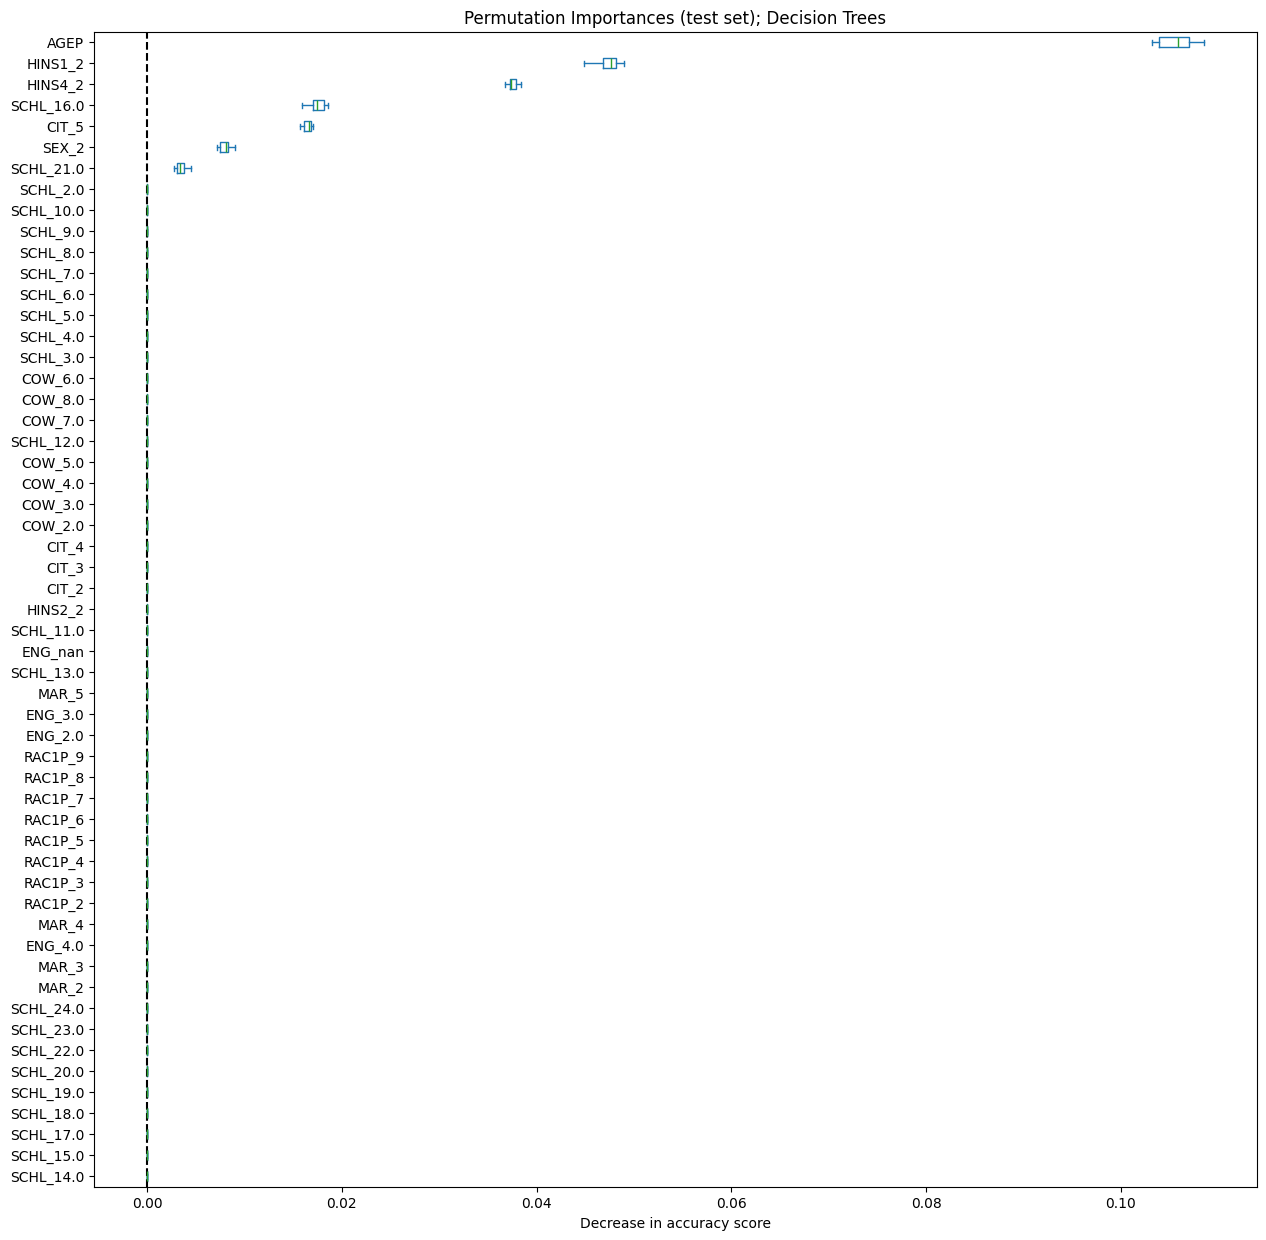

In [58]:
from sklearn.inspection import permutation_importance
#LogR = LogisticRegression(max_iter=5000, penalty ="l2", C= 0.8497534359086438, tol = 1e-4, solver = "saga").fit(X_train, y_train)
#permutation_importance(LogR, X_test, y_test, n_repeats = 30, random_state = 0)
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)
# Set the figure size
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the boxplot
importances.plot.box(ax=ax, vert=False, whis=10)
ax.set_title("Permutation Importances (test set); Decision Trees")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")

plt.show()



In [59]:
#!pip install shap
import shap

In [60]:
data

,AGEP,HINS1_2,HINS2_2,HINS4_2,CIT_2,CIT_3,CIT_4,CIT_5,COW_2.0,COW_3.0,...,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,ENG_2.0,ENG_3.0,ENG_4.0,ENG_nan
0,-0.48,True,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
6,-0.84,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
7,0.92,True,True,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
10,-0.36,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13,-0.96,True,False,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378801,-0.16,False,True,True,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
378802,-0.12,False,True,True,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
378807,0.76,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
378811,1.08,True,True,True,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False


In [73]:
############# SHAP ################
## Logistic Regression


explainer = shap.Explainer(
    LogR, X_train, feature_names=X_train.columns)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values.values)


TypeError: The beeswarm plot requires an `Explanation` object as the `shap_values` argument.

In [77]:
print(len(shap_values.values))
#for i in shap_values.values: 
#    print(i)

39133


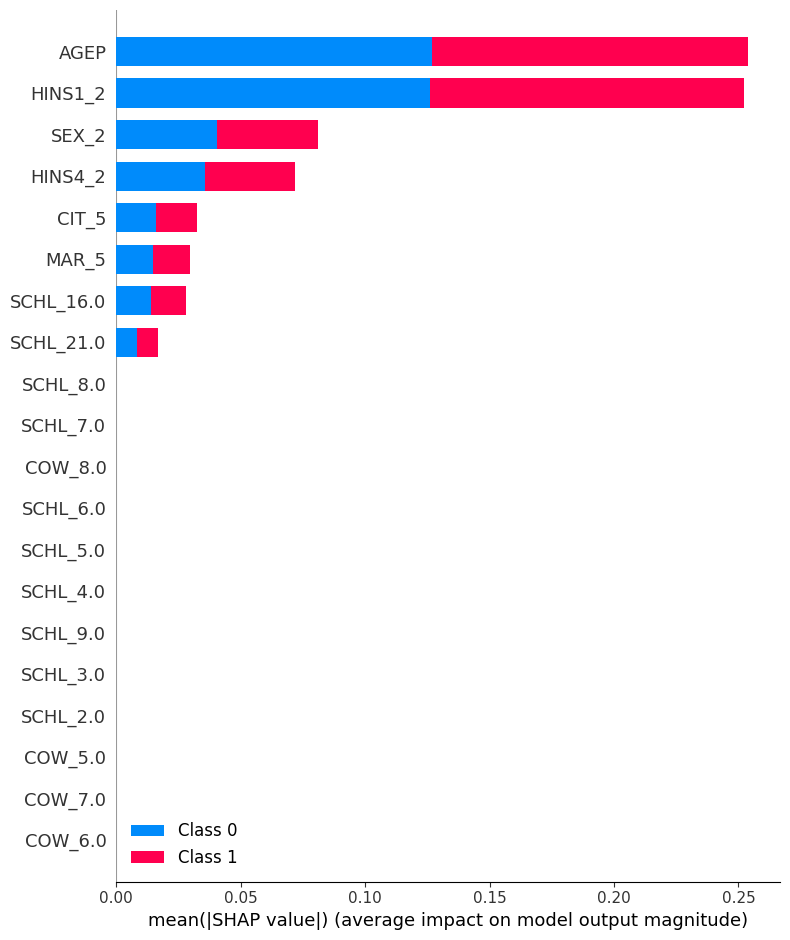

In [43]:


explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(data)

#shap.force_plot(explainer.expected_value, shap_values[0, :], data.iloc[0, :])
# make sure the SHAP values add up to marginal predictions
#np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()
shap.summary_plot(shap_values, data)

In [ ]:
explainer = shap.TreeExplainer(clf)
explanation = explainer(Xd)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()